<a href="https://colab.research.google.com/github/VasylDvorakDS/Stock-Returns-with-RNN/blob/master/Stock_Returns_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [2]:


# More imports
from tensorflow import keras
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [3]:


# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')



In [4]:


df.head()



,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:


df.tail()



,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [6]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [7]:


# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()



In [8]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [9]:


### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)



Epoch 1/80
20/20 [==============================] - 13s 146ms/step - loss: 0.1116 - val_loss: 0.1022
Epoch 2/80
20/20 [==============================] - 1s 37ms/step - loss: 0.0176 - val_loss: 0.0532
Epoch 3/80
20/20 [==============================] - 1s 27ms/step - loss: 0.0068 - val_loss: 0.0252
Epoch 4/80
20/20 [==============================] - 0s 23ms/step - loss: 0.0058 - val_loss: 0.0266
Epoch 5/80
20/20 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0296
Epoch 6/80
20/20 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0360
Epoch 7/80
20/20 [==============================] - 0s 22ms/step - loss: 0.0059 - val_loss: 0.0647
Epoch 8/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0094 - val_loss: 0.0624
Epoch 9/80
20/20 [==============================] - 0s 18ms/step - loss: 0.0069 - val_loss: 0.0368
Epoch 10/80
20/20 [==============================] - 0s 18ms/step - loss: 0.0063 - val_loss: 0.0248
Epoch 1

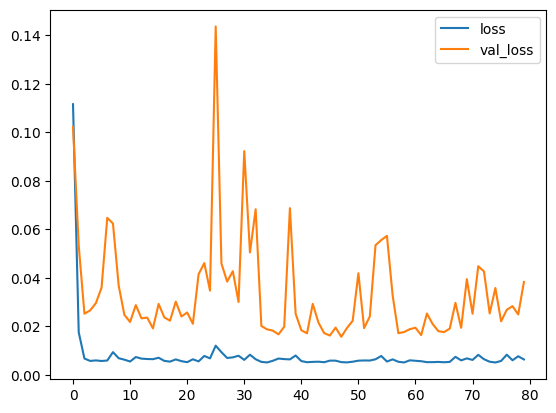

In [10]:


# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()



40/40 [==============================] - 1s 2ms/step
(1249, 1)


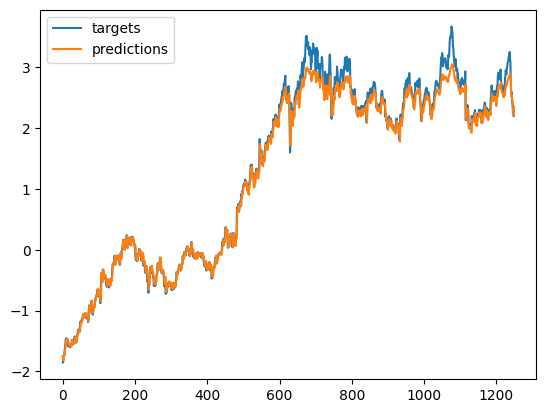

In [11]:


# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()



1/1 [==============================] - 0s 31ms/step


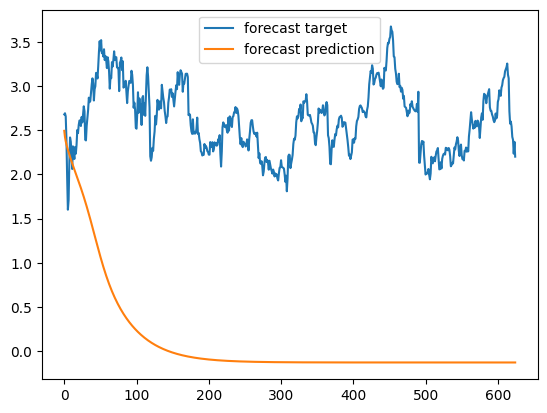

In [12]:


# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()



In [13]:


# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]



In [14]:


df.head()



,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [15]:


# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']



<Axes: >

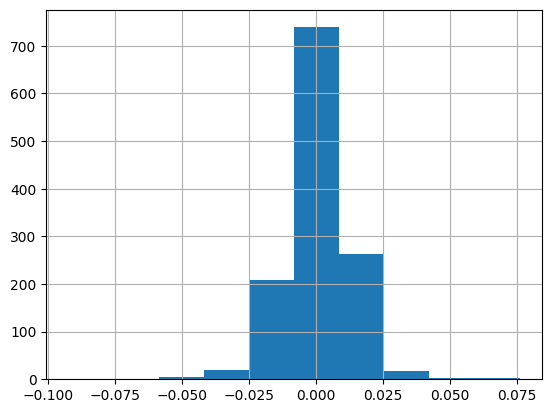

In [16]:


# Now let's try an LSTM to predict returns
df['Return'].hist()



In [17]:


series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()



In [18]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [19]:


### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)



Epoch 1/80
20/20 [==============================] - 3s 40ms/step - loss: 1.0122 - val_loss: 1.1399
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9931 - val_loss: 1.1420
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9868 - val_loss: 1.1452
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9857 - val_loss: 1.1485
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9860 - val_loss: 1.1459
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9832 - val_loss: 1.1625
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9845 - val_loss: 1.1478
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9796 - val_loss: 1.1552
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9808 - val_loss: 1.1550
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9761 - val_loss: 1.1553
Epoch 11/8

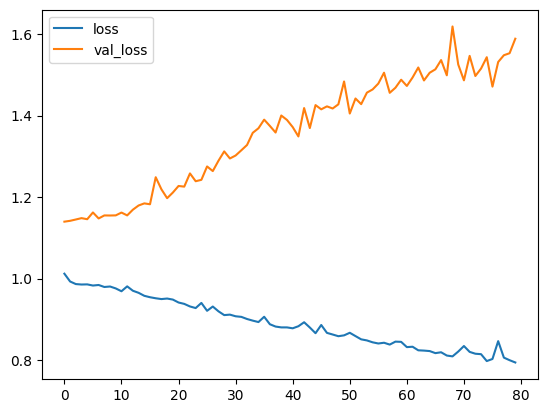

In [20]:


# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()



39/39 [==============================] - 1s 2ms/step
(1248, 1)


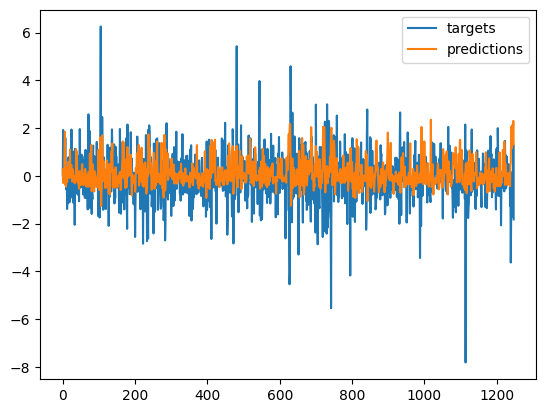

In [21]:


# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()



1/1 [==============================] - 0s 23ms/step


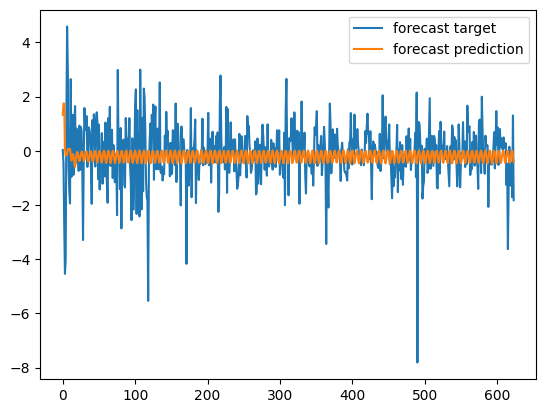

In [22]:


# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()



In [23]:


# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values



In [24]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1

In [25]:


# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)



In [26]:


# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)



In [27]:


# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)



In [28]:


# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy'],
)



In [29]:


# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)



Epoch 1/300
27/27 [==============================] - 3s 31ms/step - loss: 0.6976 - accuracy: 0.4505 - val_loss: 0.6941 - val_accuracy: 0.5122
Epoch 2/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6924 - accuracy: 0.5042 - val_loss: 0.6953 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6925 - val_accuracy: 0.5220
Epoch 4/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6929 - val_accuracy: 0.5244
Epoch 5/300
27/27 [==============================] - 0s 15ms/step - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6946 - val_accuracy: 0.4951
Epoch 6/300
27/27 [==============================] - 0s 14ms/step - loss: 0.6900 - accuracy: 0.5316 - val_loss: 0.6938 - val_accuracy: 0.4902
Epoch 7/300
27/27 [==============================] - 0s 14ms/step - loss: 0.6904 - accuracy: 0.5399 - val_loss: 0.6976 - val_accuracy: 0.4927
Epoch 8

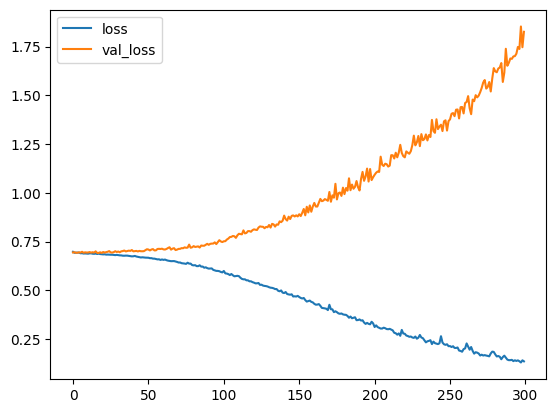

In [30]:


# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



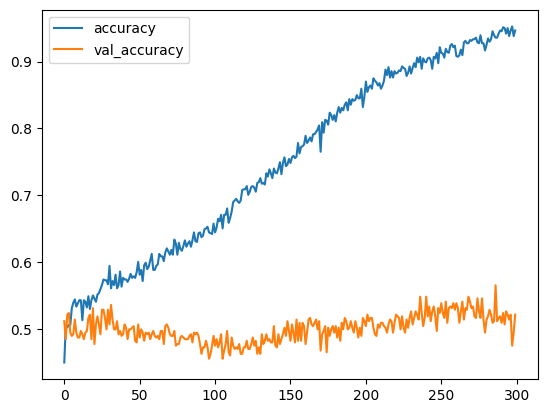

In [31]:


# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

